Поиск цен на момент покупки...

Учтено покупок после поиска цен: 4
Расчет относительной стоимости портфеля...
Расчет завершен.


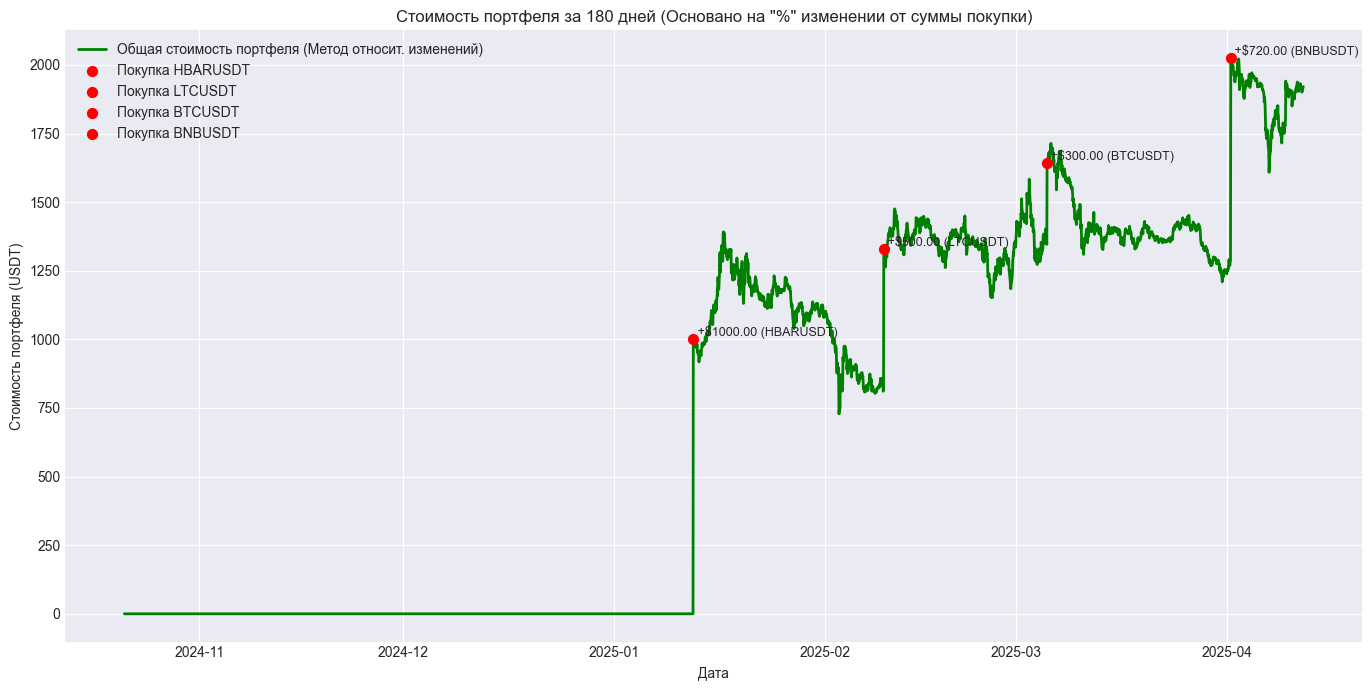


Данные портфеля с найденными ценами покупки:
                 Дата     Актив  Общая стоимость  Purchase_Price_Actual  \
0 2025-01-12 14:29:48  HBARUSDT           1000.0                0.28239   
1 2025-02-09 14:21:24   LTCUSDT            500.0              108.02000   
2 2025-03-05 14:21:17   BTCUSDT            300.0            88344.25000   
3 2025-04-01 14:21:01   BNBUSDT            720.0              615.26000   

  Actual_Purchase_Time_Index  
0        2025-01-12 15:00:00  
1        2025-02-09 15:00:00  
2        2025-03-05 15:00:00  
3        2025-04-01 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  HBARUSDT_Price  LTCUSDT_Price  \
Open time                                                                  
2025-04-12 03:00:00           1903.455886         0.16620          75.29   
2025-04-12 04:00:00           1910.445666         0.16679          75.83   
2025-04-12 05:00:00           1912.913589         0.16714         

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
portfolio_data = {
    "ID": [3, 2, 1, 0],
    "Дата": ["2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка"], # Не используется
    "Актив": ["HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"], # Нужно для связи с ценами
    "Количество": [4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [0.17, 76.11, 83.26, 58.69], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00], # Не используется
    "Общая стоимость": [1000.00, 500.00, 300.00, 720.00] # КЛЮЧЕВОЙ ПАРАМЕТР
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
# Сортировка ОЧЕНЬ важна для правильной обработки покупок
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    # Нам нужен только столбец Close для цен
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    # Явно указываем тип float
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')

# Объединение данных по ценам
historical_prices = pd.concat([btc_data, bnb_data, ltc_data, hbar_data], axis=1)

# Определяем временной диапазон
if today is None:
    today = historical_prices.index.max() # Берем последнюю дату из данных
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости (Метод относительных изменений) ---

# Фильтрация объединенных данных по заданному ИСТОРИЧЕСКОМУ диапазону
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
# Используем .copy() чтобы избежать SettingWithCopyWarning

# Заполнение возможных пропусков (важно перед поиском цен покупки)
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

# Проверка на наличие NaN после заполнения
if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    # Можно либо удалить строки с NaN, либо применить другую стратегию
    historical_prices_filtered = historical_prices_filtered.dropna()

# Добавляем столбцы для хранения цены покупки и индекса времени для каждой транзакции
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

# Находим фактическую цену в исторических данных НА МОМЕНТ ПОКУПКИ или сразу после
print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'

    if price_col not in historical_prices_filtered.columns:
        print(f"Ошибка: Столбец цен {price_col} не найден для актива {asset}.")
        continue # Пропускаем эту покупку

    # Ищем первый индекс времени в historical_prices_filtered >= даты покупки
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]

        # Проверка, что цена не NaN и не 0
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Для {asset} ({purchase_date}): Найдена цена {purchase_price:.4f} на {actual_purchase_time_index}")
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index}. Покупка будет проигнорирована.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

    else:
        # Если дата покупки позже всех исторических данных, покупку нельзя учесть
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date}. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

# Удаляем строки из портфеля, для которых не удалось найти действительное время/цену покупки
portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

print(f"\nУчтено покупок после поиска цен: {len(portfolio_df)}")
if len(portfolio_df) == 0:
      print("Ошибка: Не найдено действительных покупок для анализа. Проверьте даты и наличие данных.")
      exit()

# Инициализируем столбец общей стоимости нулями
historical_prices_filtered['Total_Value_Relative'] = 0.0

# Рассчитываем стоимость для каждого момента времени
print("Расчет относительной стоимости портфеля...")
# Итерируемся по временным меткам в отфильтрованных данных
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    # Итерируемся по каждой ДЕЙСТВИТЕЛЬНОЙ покупке в портфеле
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index'] # Фактическое время из индекса цен

        # Учитываем покупку только если текущее время >= времени покупки
        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость'] # Берем исходную сумму
            purchase_price = purchase_row['Purchase_Price_Actual'] # Цена в момент покупки
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            # Получаем текущую цену актива
            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            # Рассчитываем текущую стоимость этой конкретной инвестиции
            # на основе ПРОЦЕНТНОГО изменения цены с момента покупки
            if pd.notna(current_price): # Проверяем, что текущая цена действительна
                # Коэффициент изменения цены (Current Price / Purchase Price)
                price_ratio = current_price / purchase_price # purchase_price уже проверена > 0
                current_investment_value = initial_investment * price_ratio
            else:
                # Если текущая цена неизвестна, сохраняем последнюю известную стоимость
                # Найдем предыдущий индекс
                prev_index = historical_prices_filtered.index[historical_prices_filtered.index < current_time_index]
                if not prev_index.empty:
                     # Повторяем расчет для предыдущего индекса (приблизительно)
                     # Это сложная логика, проще считать вклад 0 или оставить как есть
                     prev_price = historical_prices_filtered.loc[prev_index[-1], price_col]
                     if pd.notna(prev_price):
                          price_ratio = prev_price / purchase_price
                          current_investment_value = initial_investment * price_ratio
                     else: # Если и предыдущая цена NaN
                          current_investment_value = 0 # Безопасное значение по умолчанию
                else: # Если это самая первая точка
                     current_investment_value = 0 # Безопасное значение по умолчанию
                print(f"Предупреждение: Отсутствует текущая цена для {asset} на {current_time_index}. Используется приближенное значение.")


            # Добавляем стоимость этой инвестиции к общей стоимости на текущий момент
            current_total_value += current_investment_value

    # Записываем общую стоимость для текущего времени
    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value

print("Расчет завершен.")

# --- Шаг 4: Визуализация ---
plt.style.use('seaborn-v0_8-darkgrid') # Используем стиль для лучшего вида
plt.figure(figsize=(14, 7))

plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Общая стоимость портфеля (Метод относит. изменений)', color='green', linewidth=2)

# Добавим отметки о покупках
unique_labels = set() # Для уникальных меток в легенде
portfolio_in_range = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history]

for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Ищем точное значение в индексе для корректного отображения
    if plot_time in historical_prices_filtered.index:
        # Стоимость портфеля СРАЗУ ПОСЛЕ добавления этой инвестиции
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        label_text = f'Покупка {row["Актив"]}'
        # Добавляем метку в легенду только один раз для каждого типа события
        current_label = label_text if label_text not in unique_labels else ""
        if current_label: unique_labels.add(label_text)

        plt.scatter(plot_time, value_at_purchase, color='red', s=50, zorder=5, label=current_label) # s - размер точки
        # Текст с названием актива и суммой покупки
        plt.text(plot_time + pd.Timedelta(hours=1), value_at_purchase, # Смещаем текст чуть вправо
                 f" +${row['Общая стоимость']:.2f} ({row['Актив']})",
                 fontsize=9, verticalalignment='bottom', horizontalalignment='left')
    else:
         # Это не должно происходить, если проверка на NaN была успешной
         print(f"Предупреждение: Не удалось найти индекс {plot_time} для отметки покупки {row['Актив']}")


plt.title(f'Стоимость портфеля за {days_history} дней (Основано на "%" изменении от суммы покупки)')
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля (USDT)')
plt.grid(True)

# Создаем легенду, избегая дубликатов
handles, labels = plt.gca().get_legend_handles_labels()
# Убираем дубликаты, сохраняя порядок
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout() # Улучшает размещение элементов
plt.show()

# Вывод данных для проверки
print("\nДанные портфеля с найденными ценами покупки:")
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']])

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
# Показываем итоговую стоимость и цены активов для сравнения
price_cols_to_show = [f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns]
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].tail())

print(f"\nРассчитанные данные портфеля (первые 5 записей):")
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].head())

Поиск цен на момент покупки...
Расчет кумулятивной стоимости...
Расчет вклада и P&L для каждой покупки...
Расчеты завершены.


C:\Users\igora\AppData\Local\Temp\ipykernel_13200\1422278249.py:173: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(purchase_pnl_cols)) # tab20 - хорошая палитра для различимых цветов


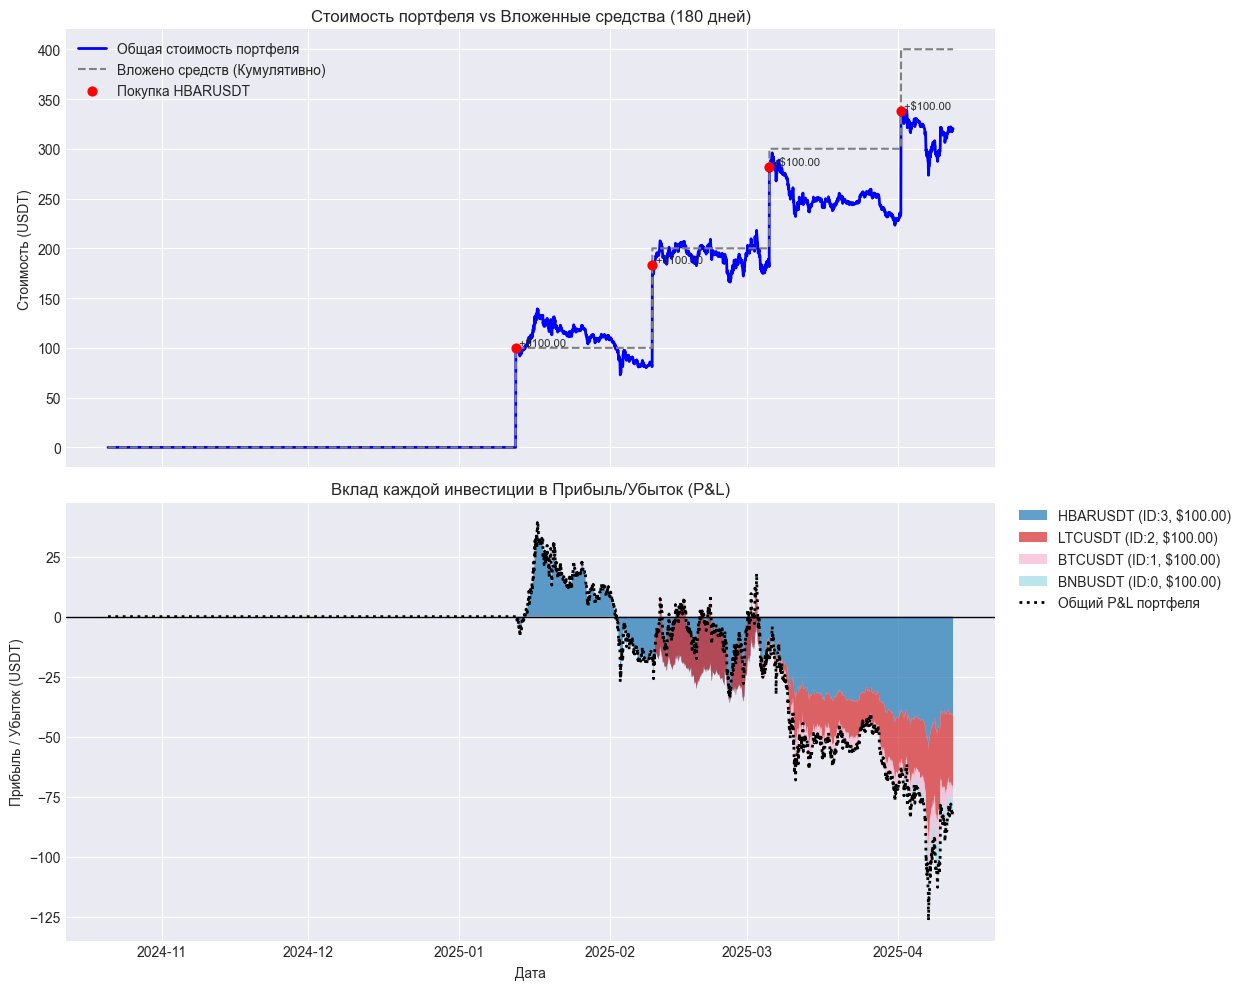


Данные портфеля с найденными ценами:
   ID                Дата     Актив  Общая стоимость  Purchase_Price_Actual  \
0   3 2025-01-12 14:29:48  HBARUSDT            100.0                0.28239   
1   2 2025-02-09 14:21:24   LTCUSDT            100.0              108.02000   
2   1 2025-03-05 14:21:17   BTCUSDT            100.0            88344.25000   
3   0 2025-04-01 14:21:01   BNBUSDT            100.0              615.26000   

  Actual_Purchase_Time_Index  
0        2025-01-12 15:00:00  
1        2025-02-09 15:00:00  
2        2025-03-05 15:00:00  
3        2025-04-01 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Cumulative_Cost  Total_Value_Relative  Total_PnL  \
Open time                                                               
2025-04-12 03:00:00            400.0            317.564950 -82.435050   
2025-04-12 04:00:00            400.0            318.762361 -81.237639   
2025-04-12 05:00:00            400.0            319.143348 -80.856

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict # Для уникальных меток в легенде

# --- Настройки ---
days_history = 180
today = pd.Timestamp('2025-04-19')
# today = None # Для использования последней даты из данных

# --- Шаг 1: Загрузка данных о портфеле ---
portfolio_data = {
    "ID": [2, 0, 1, 3], # ID могут быть произвольными
    "Дата": ["2025-02-09T14:21:24.000", "2025-04-01T14:21:01.000", "2025-03-05T14:21:17.000", "2025-01-12T14:29:48.000"], # УКАЖИТЕ ВАШИ РЕАЛЬНЫЕ ДАТЫ ПОКУПОК!
    "Актив": ["LTCUSDT", "BNBUSDT", "BTCUSDT", "HBARUSDT"],
    "Общая стоимость": [100.00, 100.00, 100.00, 100.00] # КЛЮЧЕВОЙ ПАРАМЕТР
    # Остальные столбцы из исходных данных портфеля не нужны для этого расчета
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')

historical_prices = pd.concat([btc_data, bnb_data, ltc_data, hbar_data], axis=1)

if today is None:
    today = historical_prices.index.max()
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчеты ---

historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: NaN в данных после заполнения. Удаление строк.")
    historical_prices_filtered = historical_prices_filtered.dropna()

portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns: continue
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]
    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
        else: portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT
    else: portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

if len(portfolio_df) == 0:
    print("Ошибка: Нет действительных покупок для анализа.")
    exit()

# Расчет кумулятивной стоимости (бенчмарк)
print("Расчет кумулятивной стоимости...")
historical_prices_filtered['Cumulative_Cost'] = 0.0
for _, row in portfolio_df.iterrows():
    cost = row['Общая стоимость']
    purchase_time = row['Actual_Purchase_Time_Index']
    # Увеличиваем стоимость для всех моментов времени >= времени покупки
    historical_prices_filtered.loc[historical_prices_filtered.index >= purchase_time, 'Cumulative_Cost'] += cost

# Расчет стоимости и P&L для КАЖДОЙ отдельной покупки
print("Расчет вклада и P&L для каждой покупки...")
purchase_value_cols = []
purchase_pnl_cols = []
purchase_labels = []

for index, purchase_row in portfolio_df.iterrows():
    purchase_id = purchase_row['ID'] # Используем ID для уникальности
    asset = purchase_row['Актив']
    initial_investment = purchase_row['Общая стоимость']
    purchase_price = purchase_row['Purchase_Price_Actual']
    purchase_time = purchase_row['Actual_Purchase_Time_Index']
    price_col = f'{asset}_Price'

    # Создаем уникальные имена столбцов
    value_col_name = f"Value_ID{purchase_id}_{asset}"
    pnl_col_name = f"PnL_ID{purchase_id}_{asset}"
    purchase_value_cols.append(value_col_name)
    purchase_pnl_cols.append(pnl_col_name)
    purchase_labels.append(f"{asset} (ID:{purchase_id}, ${initial_investment:.2f})") # Метка для легенды

    # Инициализируем столбцы
    historical_prices_filtered[value_col_name] = 0.0
    historical_prices_filtered[pnl_col_name] = 0.0

    # Вычисляем стоимость этой покупки во времени (векторизованно)
    mask = historical_prices_filtered.index >= purchase_time
    if mask.any(): # Убедимся, что есть даты после покупки
        current_prices = historical_prices_filtered.loc[mask, price_col]
        price_ratio = current_prices / purchase_price
        # Обработка NaN и бесконечности, если current_prices или purchase_price некорректны
        price_ratio = price_ratio.fillna(0).replace([np.inf, -np.inf], 0)
        current_purchase_value = initial_investment * price_ratio

        # Записываем абсолютную стоимость и P&L
        historical_prices_filtered.loc[mask, value_col_name] = current_purchase_value
        historical_prices_filtered.loc[mask, pnl_col_name] = current_purchase_value - initial_investment

# Расчет общей стоимости (сумма вкладов) и общего P&L
historical_prices_filtered['Total_Value_Relative'] = historical_prices_filtered[purchase_value_cols].sum(axis=1)
historical_prices_filtered['Total_PnL'] = historical_prices_filtered['Total_Value_Relative'] - historical_prices_filtered['Cumulative_Cost']

print("Расчеты завершены.")

# --- Шаг 4: Визуализация (2 графика) ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True) # 2 строки, 1 колонка, общая ось X

# --- График 1: Общая стоимость и Кумулятивная стоимость ---
ax1 = axes[0]
ax1.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Общая стоимость портфеля', color='blue', linewidth=2)
ax1.plot(historical_prices_filtered.index, historical_prices_filtered['Cumulative_Cost'],
         label='Вложено средств (Кумулятивно)', color='gray', linestyle='--', linewidth=1.5)

# Отметки о покупках на первом графике
portfolio_in_range = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history]
for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    if plot_time in historical_prices_filtered.index:
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        ax1.scatter(plot_time, value_at_purchase, color='red', s=40, zorder=5, label=f'Покупка {row["Актив"]}' if index == portfolio_in_range.iloc[0].name else None) # Метка только для первой точки
        ax1.text(plot_time + pd.Timedelta(hours=1), value_at_purchase,
                 f" +${row['Общая стоимость']:.2f}", fontsize=8, va='bottom', ha='left')

ax1.set_title(f'Стоимость портфеля vs Вложенные средства ({days_history} дней)')
ax1.set_ylabel('Стоимость (USDT)')
ax1.grid(True)
ax1.legend()

# --- График 2: Вклад каждой покупки в Прибыль/Убыток (P&L) ---
ax2 = axes[1]

# Используем stackplot для P&L каждой покупки
# Убедимся, что данные в столбцах PnL - числовые
pnl_data_for_stackplot = historical_prices_filtered[purchase_pnl_cols].fillna(0).astype(float)

# Генерируем цвета (можно использовать colormap)
colors = plt.cm.get_cmap('tab20', len(purchase_pnl_cols)) # tab20 - хорошая палитра для различимых цветов

ax2.stackplot(historical_prices_filtered.index, pnl_data_for_stackplot.T,
              labels=purchase_labels, # Используем созданные метки
              colors=[colors(i) for i in range(len(purchase_pnl_cols))],
              alpha=0.7) # Небольшая прозрачность

# Линия общего P&L для сравнения
ax2.plot(historical_prices_filtered.index, historical_prices_filtered['Total_PnL'],
         label='Общий P&L портфеля', color='black', linestyle=':', linewidth=2)

# Линия нуля (уровень безубыточности)
ax2.axhline(0, color='black', linestyle='-', linewidth=1)

ax2.set_title('Вклад каждой инвестиции в Прибыль/Убыток (P&L)')
ax2.set_xlabel('Дата')
ax2.set_ylabel('Прибыль / Убыток (USDT)')
ax2.grid(True)
# Легенду для stackplot лучше разместить снаружи, если много элементов
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)


# Оптимизация отображения
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Оставляем место справа для легенды ax2
plt.show()

# Вывод данных для проверки
print("\nДанные портфеля с найденными ценами:")
print(portfolio_df[['ID', 'Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']])

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
cols_to_show = ['Cumulative_Cost', 'Total_Value_Relative', 'Total_PnL'] + purchase_pnl_cols[:2] # Показать первые 2 P&L для примера
print(historical_prices_filtered[cols_to_show].tail())

Поиск цен на момент покупки...
Расчет кумулятивной стоимости...
Расчет вклада, P&L и % вклада для каждой покупки...
Расчет процентного вклада P&L...
Расчеты завершены.


C:\Users\igora\AppData\Local\Temp\ipykernel_13200\1627937234.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_pnl_cols) # tab20 - хорошая палитра для различимых цветов


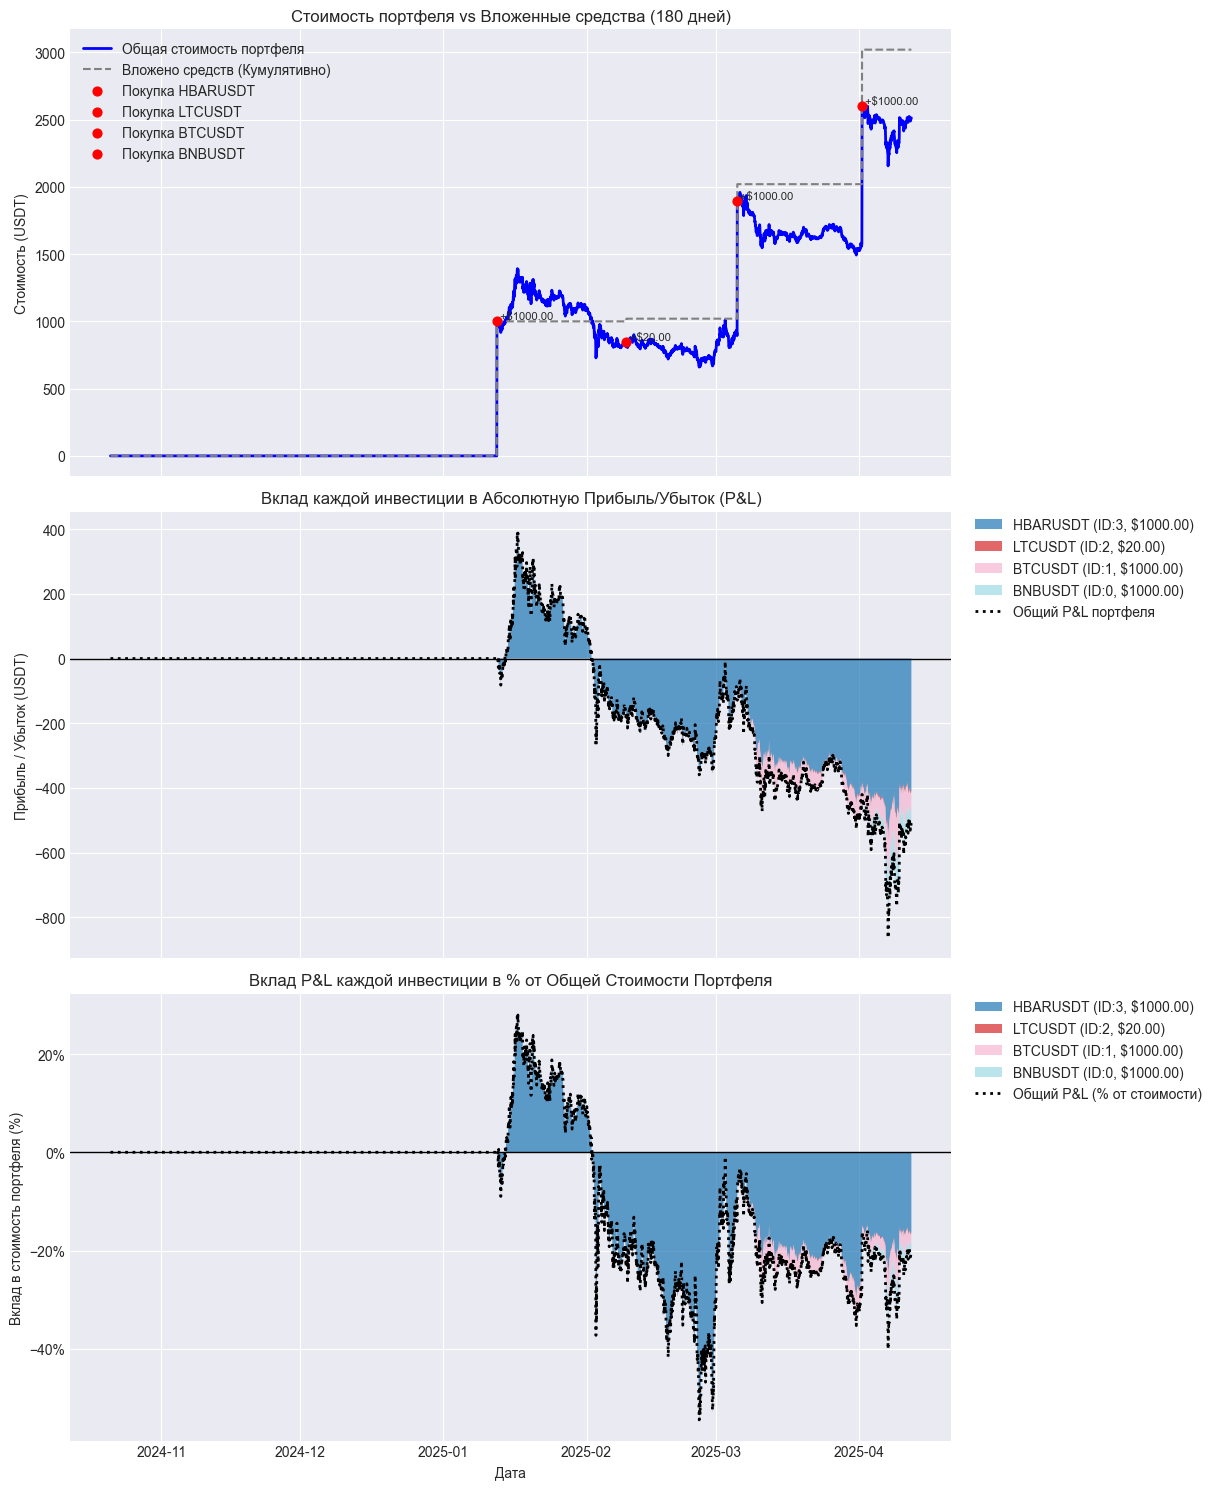


Данные портфеля с найденными ценами:
   ID                Дата     Актив  Общая стоимость  Purchase_Price_Actual  \
0   3 2025-01-12 14:29:48  HBARUSDT           1000.0                0.28239   
1   2 2025-02-09 14:21:24   LTCUSDT             20.0              108.02000   
2   1 2025-03-05 14:21:17   BTCUSDT           1000.0            88344.25000   
3   0 2025-04-01 14:21:01   BNBUSDT           1000.0              615.26000   

  Actual_Purchase_Time_Index  
0        2025-01-12 15:00:00  
1        2025-02-09 15:00:00  
2        2025-03-05 15:00:00  
3        2025-04-01 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Cumulative_Cost  Total_Value_Relative   Total_PnL  \
Open time                                                                
2025-04-12 03:00:00           3020.0           2492.588953 -527.411047   
2025-04-12 04:00:00           3020.0           2499.663974 -520.336026   
2025-04-12 05:00:00           3020.0           2503.473843 -51

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict # Для уникальных меток в легенде
import matplotlib.ticker as mtick # Для форматирования оси Y в процентах

# --- Настройки ---
days_history = 180
today = pd.Timestamp('2025-04-19')
# today = None # Для использования последней даты из данных

# --- Шаг 1: Загрузка данных о портфеле ---
portfolio_data = {
    "ID": [2, 0, 1, 3], # ID могут быть произвольными
    "Дата": ["2025-02-09T14:21:24.000", "2025-04-01T14:21:01.000", "2025-03-05T14:21:17.000", "2025-01-12T14:29:48.000"], # УКАЖИТЕ ВАШИ РЕАЛЬНЫЕ ДАТЫ ПОКУПОК!
    "Актив": ["LTCUSDT", "BNBUSDT", "BTCUSDT", "HBARUSDT"],
    "Общая стоимость": [20.00, 1000.00, 1000.00, 1000.00] # КЛЮЧЕВОЙ ПАРАМЕТР
    # Остальные столбцы из исходных данных портфеля не нужны для этого расчета
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')

historical_prices = pd.concat([btc_data, bnb_data, ltc_data, hbar_data], axis=1)

if today is None:
    today = historical_prices.index.max()
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчеты ---

historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: NaN в данных после заполнения. Удаление строк.")
    historical_prices_filtered = historical_prices_filtered.dropna()

portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns: continue
    # Ищем ближайшее ВРЕМЯ в индексе >= времени покупки
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]
    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
        else:
             print(f"Предупреждение: Не найдена или некорректная цена для {asset} в {actual_purchase_time_index}. Цена: {purchase_price}")
             portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как невалидное время
    else:
        print(f"Предупреждение: Нет исторических данных для {asset} после {purchase_date}.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как невалидное время

portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)
portfolio_df = portfolio_df.reset_index(drop=True) # Переиндексация после dropna

if len(portfolio_df) == 0:
    print("Ошибка: Нет действительных покупок для анализа в указанном диапазоне дат.")
    exit()

# Расчет кумулятивной стоимости (бенчмарк)
print("Расчет кумулятивной стоимости...")
historical_prices_filtered['Cumulative_Cost'] = 0.0
for _, row in portfolio_df.iterrows():
    cost = row['Общая стоимость']
    purchase_time = row['Actual_Purchase_Time_Index']
    # Увеличиваем стоимость для всех моментов времени >= времени покупки
    historical_prices_filtered.loc[historical_prices_filtered.index >= purchase_time, 'Cumulative_Cost'] += cost

# Расчет стоимости, P&L и процентного вклада для КАЖДОЙ отдельной покупки
print("Расчет вклада, P&L и % вклада для каждой покупки...")
purchase_value_cols = []
purchase_pnl_cols = []
purchase_perc_contrib_cols = [] # НОВЫЙ СПИСОК
purchase_labels = []

for index, purchase_row in portfolio_df.iterrows():
    purchase_id = purchase_row['ID'] # Используем ID для уникальности
    asset = purchase_row['Актив']
    initial_investment = purchase_row['Общая стоимость']
    purchase_price = purchase_row['Purchase_Price_Actual']
    purchase_time = purchase_row['Actual_Purchase_Time_Index']
    price_col = f'{asset}_Price'

    # Проверка наличия колонки с ценой актива (на всякий случай)
    if price_col not in historical_prices_filtered.columns:
        print(f"Предупреждение: Колонка цен {price_col} отсутствует в historical_prices_filtered. Пропуск покупки ID {purchase_id}.")
        continue

    # Создаем уникальные имена столбцов
    value_col_name = f"Value_ID{purchase_id}_{asset}"
    pnl_col_name = f"PnL_ID{purchase_id}_{asset}"
    perc_contrib_col_name = f"PercContrib_ID{purchase_id}_{asset}" # НОВОЕ ИМЯ
    purchase_value_cols.append(value_col_name)
    purchase_pnl_cols.append(pnl_col_name)
    purchase_perc_contrib_cols.append(perc_contrib_col_name) # ДОБАВЛЯЕМ
    purchase_labels.append(f"{asset} (ID:{purchase_id}, ${initial_investment:.2f})") # Метка для легенды

    # Инициализируем столбцы
    historical_prices_filtered[value_col_name] = 0.0
    historical_prices_filtered[pnl_col_name] = 0.0
    historical_prices_filtered[perc_contrib_col_name] = 0.0 # ИНИЦИАЛИЗИРУЕМ

    # Вычисляем стоимость этой покупки во времени (векторизованно)
    mask = historical_prices_filtered.index >= purchase_time
    if mask.any(): # Убедимся, что есть даты после покупки
        current_prices = historical_prices_filtered.loc[mask, price_col]
        # Проверяем цену покупки на ноль или NaN перед делением
        if pd.isna(purchase_price) or purchase_price == 0:
            print(f"Предупреждение: Нулевая или NaN цена покупки для {asset} ID {purchase_id} в {purchase_time}. P&L будет 0.")
            price_ratio = pd.Series(0.0, index=current_prices.index) # Отношение будет 0
        else:
            price_ratio = current_prices / purchase_price
            # Обработка NaN и бесконечности, если current_prices некорректны
            price_ratio = price_ratio.fillna(0).replace([np.inf, -np.inf], 0)

        current_purchase_value = initial_investment * price_ratio

        # Записываем абсолютную стоимость и P&L
        historical_prices_filtered.loc[mask, value_col_name] = current_purchase_value
        historical_prices_filtered.loc[mask, pnl_col_name] = current_purchase_value - initial_investment
    else:
        print(f"Предупреждение: Нет данных после времени покупки {purchase_time} для {asset} ID {purchase_id}.")


# Расчет общей стоимости (сумма вкладов) и общего P&L
historical_prices_filtered['Total_Value_Relative'] = historical_prices_filtered[purchase_value_cols].sum(axis=1)
historical_prices_filtered['Total_PnL'] = historical_prices_filtered['Total_Value_Relative'] - historical_prices_filtered['Cumulative_Cost']

# Расчет процентного вклада P&L каждой покупки в ОБЩУЮ СТОИМОСТЬ портфеля
print("Расчет процентного вклада P&L...")
for pnl_col, perc_contrib_col in zip(purchase_pnl_cols, purchase_perc_contrib_cols):
    # Делим P&L покупки на ОБЩУЮ стоимость портфеля в этот момент времени
    # Используем .divide() с fill_value=0 для обработки деления на 0 (когда общая стоимость = 0)
    percentage_contribution = historical_prices_filtered[pnl_col].divide(historical_prices_filtered['Total_Value_Relative']) * 100
    # Заменяем inf/-inf (могут возникнуть если PnL != 0, а Total_Value = 0) и NaN на 0
    historical_prices_filtered[perc_contrib_col] = percentage_contribution.replace([np.inf, -np.inf], np.nan).fillna(0)

# Расчет общего P&L в процентах от общей стоимости
historical_prices_filtered['Total_PnL_Percentage'] = (historical_prices_filtered['Total_PnL']
                                                    .divide(historical_prices_filtered['Total_Value_Relative']) * 100)\
                                                    .replace([np.inf, -np.inf], np.nan).fillna(0)


print("Расчеты завершены.")

# --- Шаг 4: Визуализация (3 графика) ---
plt.style.use('seaborn-v0_8-darkgrid')
# Увеличим высоту фигуры для 3 графиков
fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True) # 3 строки, 1 колонка, общая ось X

# --- График 1: Общая стоимость и Кумулятивная стоимость ---
ax1 = axes[0]
ax1.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Общая стоимость портфеля', color='blue', linewidth=2)
ax1.plot(historical_prices_filtered.index, historical_prices_filtered['Cumulative_Cost'],
         label='Вложено средств (Кумулятивно)', color='gray', linestyle='--', linewidth=1.5)

# Отметки о покупках на первом графике
portfolio_in_range = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history]
unique_labels = set()
for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Убедимся, что время есть в индексе перед попыткой loc
    if plot_time in historical_prices_filtered.index:
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        label = f'Покупка {row["Актив"]}'
        if label not in unique_labels:
             ax1.scatter(plot_time, value_at_purchase, color='red', s=40, zorder=5, label=label)
             unique_labels.add(label)
        else:
             ax1.scatter(plot_time, value_at_purchase, color='red', s=40, zorder=5) # Без метки

        ax1.text(plot_time + pd.Timedelta(hours=1), value_at_purchase,
                 f" +${row['Общая стоимость']:.2f}", fontsize=8, va='bottom', ha='left')
    else:
        print(f"Предупреждение: Время покупки {plot_time} для {row['Актив']} ID {row['ID']} не найдено в индексе для графика 1.")


ax1.set_title(f'Стоимость портфеля vs Вложенные средства ({days_history} дней)')
ax1.set_ylabel('Стоимость (USDT)')
ax1.grid(True)
# Используем OrderedDict для уникальных меток в легенде ax1
handles, labels = ax1.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())


# --- График 2: Вклад каждой покупки в Абсолютную Прибыль/Убыток (P&L) ---
ax2 = axes[1]

# Используем stackplot для P&L каждой покупки
# Убедимся, что данные в столбцах PnL - числовые
pnl_data_for_stackplot = historical_prices_filtered[purchase_pnl_cols].fillna(0).astype(float)

# Генерируем цвета (можно использовать colormap)
# Убедимся, что количество цветов соответствует количеству столбцов PnL
num_pnl_cols = len(purchase_pnl_cols)
if num_pnl_cols > 0:
    colors = plt.cm.get_cmap('tab20', num_pnl_cols) # tab20 - хорошая палитра для различимых цветов

    ax2.stackplot(historical_prices_filtered.index, pnl_data_for_stackplot.T,
                  labels=purchase_labels, # Используем созданные метки
                  colors=[colors(i) for i in range(num_pnl_cols)],
                  alpha=0.7) # Небольшая прозрачность

    # Линия общего P&L для сравнения
    ax2.plot(historical_prices_filtered.index, historical_prices_filtered['Total_PnL'],
             label='Общий P&L портфеля', color='black', linestyle=':', linewidth=2)

    # Линия нуля (уровень безубыточности)
    ax2.axhline(0, color='black', linestyle='-', linewidth=1)

    ax2.set_title('Вклад каждой инвестиции в Абсолютную Прибыль/Убыток (P&L)')
    ax2.set_ylabel('Прибыль / Убыток (USDT)')
    ax2.grid(True)
    # Легенду для stackplot лучше разместить снаружи
    ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
else:
    ax2.text(0.5, 0.5, 'Нет данных P&L для отображения', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    ax2.set_title('Вклад каждой инвестиции в Абсолютную Прибыль/Убыток (P&L)')
    ax2.set_ylabel('Прибыль / Убыток (USDT)')


# --- График 3: Вклад P&L каждой покупки в % от Общей Стоимости Портфеля ---
ax3 = axes[2]

# Используем stackplot для процентного вклада P&L каждой покупки
# Убедимся, что данные - числовые
perc_contrib_data_for_stackplot = historical_prices_filtered[purchase_perc_contrib_cols].fillna(0).astype(float)

# Используем те же цвета
num_perc_cols = len(purchase_perc_contrib_cols)
if num_perc_cols > 0 and num_perc_cols == num_pnl_cols: # Убедимся, что цвета совпадают
    ax3.stackplot(historical_prices_filtered.index, perc_contrib_data_for_stackplot.T,
                  labels=purchase_labels, # Используем те же метки
                  colors=[colors(i) for i in range(num_perc_cols)],
                  alpha=0.7)

    # Линия общего P&L в % от общей стоимости
    ax3.plot(historical_prices_filtered.index, historical_prices_filtered['Total_PnL_Percentage'],
             label='Общий P&L (% от стоимости)', color='black', linestyle=':', linewidth=2)

    # Линия нуля
    ax3.axhline(0, color='black', linestyle='-', linewidth=1)

    ax3.set_title('Вклад P&L каждой инвестиции в % от Общей Стоимости Портфеля')
    ax3.set_xlabel('Дата')
    ax3.set_ylabel('Вклад в стоимость портфеля (%)')
    ax3.yaxis.set_major_formatter(mtick.PercentFormatter()) # Форматируем ось Y в %
    ax3.grid(True)
    # Легенда также снаружи
    ax3.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
else:
     ax3.text(0.5, 0.5, 'Нет данных % вклада для отображения', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
     ax3.set_title('Вклад P&L каждой инвестиции в % от Общей Стоимости Портфеля')
     ax3.set_ylabel('Вклад в стоимость портфеля (%)')


# Оптимизация отображения
# Оставляем место справа для легенд ax2 и ax3
plt.tight_layout(rect=[0, 0, 0.88, 1]) # Уменьшил правую границу еще немного
plt.show()

# Вывод данных для проверки
print("\nДанные портфеля с найденными ценами:")
print(portfolio_df[['ID', 'Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']])

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
cols_to_show = ['Cumulative_Cost', 'Total_Value_Relative', 'Total_PnL', 'Total_PnL_Percentage']
# Добавим пару столбцов P&L и % вклада для примера, если они есть
if len(purchase_pnl_cols) > 0:
    cols_to_show.append(purchase_pnl_cols[0])
if len(purchase_perc_contrib_cols) > 0:
    cols_to_show.append(purchase_perc_contrib_cols[0])

# Проверим, существуют ли выбранные колонки перед выводом
cols_to_show = [col for col in cols_to_show if col in historical_prices_filtered.columns]
if cols_to_show:
    print(historical_prices_filtered[cols_to_show].tail())
else:
    print("Нет данных для отображения в итоговой таблице.")

In [38]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt # No longer needed
# from collections import OrderedDict # No longer needed for legend
# import matplotlib.ticker as mtick # No longer needed

# --- Plotly Imports ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px # For color palettes

# --- Настройки ---
days_history = 180
today = pd.Timestamp('2025-04-19')
# today = None # Для использования последней даты из данных

# --- Шаг 1: Загрузка данных о портфеле ---
portfolio_data = {
    "ID": [2, 0, 1, 3], # ID могут быть произвольными
    "Дата": ["2025-02-09T14:21:24.000", "2025-04-01T14:21:01.000", "2025-03-05T14:21:17.000", "2025-01-12T14:29:48.000"], # УКАЖИТЕ ВАШИ РЕАЛЬНЫЕ ДАТЫ ПОКУПОК!
    "Актив": ["LTCUSDT", "BNBUSDT", "BTCUSDT", "HBARUSDT"],
    "Общая стоимость": [20.00, 1000.00, 1000.00, 1000.00] # КЛЮЧЕВОЙ ПАРАМЕТР
    # Остальные столбцы из исходных данных портфеля не нужны для этого расчета
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных ---
# Assume files are in the correct location as per the original script
try:
    # Укажите ПРАВИЛЬНЫЕ пути
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')

historical_prices = pd.concat([btc_data, bnb_data, ltc_data, hbar_data], axis=1)

if today is None:
    today = historical_prices.index.max()
# Ensure today is timezone-naive or consistent with index
if historical_prices.index.tz is not None:
    today = today.tz_localize(None) # Make today timezone naive if index is naive
else:
    today = today # Assume today is already naive if index is naive

start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчеты ---

# Ensure start_date_history is compatible with index timezone (or lack thereof)
if historical_prices.index.tz is not None and start_date_history.tz is None:
     start_date_history = start_date_history.tz_localize(historical_prices.index.tz)
elif historical_prices.index.tz is None and start_date_history.tz is not None:
     start_date_history = start_date_history.tz_localize(None)


historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: NaN в данных после заполнения. Удаление строк.")
    historical_prices_filtered = historical_prices_filtered.dropna()

portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

# Ensure portfolio 'Дата' is timezone-naive or consistent with index
if historical_prices_filtered.index.tz is not None:
    portfolio_df['Дата'] = portfolio_df['Дата'].dt.tz_localize(None).dt.tz_localize(historical_prices_filtered.index.tz)
else:
    portfolio_df['Дата'] = portfolio_df['Дата'].dt.tz_localize(None) # Make naive

print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns: continue

    # Find the first available time >= purchase time in the filtered data index
    relevant_prices_index = historical_prices_filtered.index[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices_index.empty:
        actual_purchase_time_index = relevant_prices_index[0]
        try:
            purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]
            if pd.notna(purchase_price) and purchase_price > 0:
                portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
                portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
                # print(f"  Found price for {asset} at {actual_purchase_time_index}: {purchase_price}") # Debug print
            else:
                 print(f"Предупреждение: Не найдена или некорректная цена для {asset} в {actual_purchase_time_index}. Цена: {purchase_price}")
                 portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как невалидное время
        except KeyError:
             print(f"Предупреждение: KeyError при поиске цены для {asset} в {actual_purchase_time_index}.")
             portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как невалидное время
    else:
        # If no index found >= purchase date, try the closest *before* if it's within the filtered range
        relevant_prices_index_before = historical_prices_filtered.index[historical_prices_filtered.index < purchase_date]
        if not relevant_prices_index_before.empty:
            actual_purchase_time_index = relevant_prices_index_before[-1] # Closest before
            print(f"Предупреждение: Нет данных для {asset} в или после {purchase_date}. Используется ближайшее время *до*: {actual_purchase_time_index}")
            try:
                 purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]
                 if pd.notna(purchase_price) and purchase_price > 0:
                     portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
                     portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
                 else:
                    print(f"Предупреждение: Некорректная цена для {asset} в {actual_purchase_time_index} (время до покупки). Цена: {purchase_price}")
                    portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT
            except KeyError:
                print(f"Предупреждение: KeyError при поиске цены для {asset} в {actual_purchase_time_index} (время до покупки).")
                portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT
        else:
            print(f"Предупреждение: Нет исторических данных для {asset} около {purchase_date} в отфильтрованном диапазоне.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как невалидное время


portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)
portfolio_df = portfolio_df.reset_index(drop=True) # Переиндексация после dropna

if len(portfolio_df) == 0:
    print("Ошибка: Нет действительных покупок для анализа в указанном диапазоне дат.")
    exit()

# Расчет кумулятивной стоимости (бенчмарк)
print("Расчет кумулятивной стоимости...")
historical_prices_filtered['Cumulative_Cost'] = 0.0
for _, row in portfolio_df.iterrows():
    cost = row['Общая стоимость']
    purchase_time = row['Actual_Purchase_Time_Index']
    historical_prices_filtered.loc[historical_prices_filtered.index >= purchase_time, 'Cumulative_Cost'] += cost

# Расчет стоимости, P&L и процентного вклада для КАЖДОЙ отдельной покупки
print("Расчет вклада, P&L и % вклада для каждой покупки...")
purchase_value_cols = []
purchase_pnl_cols = []
purchase_perc_contrib_cols = []
purchase_labels = [] # Метки для легенды и идентификации
purchase_ids_assets = [] # Для сопоставления с цветами

for index, purchase_row in portfolio_df.iterrows():
    purchase_id = purchase_row['ID']
    asset = purchase_row['Актив']
    initial_investment = purchase_row['Общая стоимость']
    purchase_price = purchase_row['Purchase_Price_Actual']
    purchase_time = purchase_row['Actual_Purchase_Time_Index']
    price_col = f'{asset}_Price'

    if price_col not in historical_prices_filtered.columns:
        print(f"Предупреждение: Колонка цен {price_col} отсутствует. Пропуск покупки ID {purchase_id}.")
        continue

    value_col_name = f"Value_ID{purchase_id}_{asset}"
    pnl_col_name = f"PnL_ID{purchase_id}_{asset}"
    perc_contrib_col_name = f"PercContrib_ID{purchase_id}_{asset}"
    label = f"{asset} (ID:{purchase_id}, ${initial_investment:.2f})" # Метка для легенды

    purchase_value_cols.append(value_col_name)
    purchase_pnl_cols.append(pnl_col_name)
    purchase_perc_contrib_cols.append(perc_contrib_col_name)
    purchase_labels.append(label)
    purchase_ids_assets.append(f"{asset}_ID{purchase_id}") # Уникальный идентификатор для цвета

    historical_prices_filtered[value_col_name] = 0.0
    historical_prices_filtered[pnl_col_name] = 0.0
    historical_prices_filtered[perc_contrib_col_name] = 0.0

    mask = historical_prices_filtered.index >= purchase_time
    if mask.any():
        current_prices = historical_prices_filtered.loc[mask, price_col]
        if pd.isna(purchase_price) or purchase_price <= 0: # Check for non-positive price
            print(f"Предупреждение: Нулевая, отрицательная или NaN цена покупки для {asset} ID {purchase_id} в {purchase_time}. P&L будет 0.")
            price_ratio = pd.Series(0.0, index=current_prices.index)
        else:
            price_ratio = current_prices / purchase_price
            price_ratio = price_ratio.fillna(0).replace([np.inf, -np.inf], 0)

        current_purchase_value = initial_investment * price_ratio
        historical_prices_filtered.loc[mask, value_col_name] = current_purchase_value
        historical_prices_filtered.loc[mask, pnl_col_name] = current_purchase_value - initial_investment
    else:
        print(f"Предупреждение: Нет данных после времени покупки {purchase_time} для {asset} ID {purchase_id}.")

# Расчет общей стоимости и P&L
historical_prices_filtered['Total_Value_Relative'] = historical_prices_filtered[purchase_value_cols].sum(axis=1)
# Ensure Total_Value_Relative is not zero before calculating PnL relative to it
historical_prices_filtered['Total_PnL'] = historical_prices_filtered['Total_Value_Relative'] - historical_prices_filtered['Cumulative_Cost']

# Расчет процентного вклада P&L
print("Расчет процентного вклада P&L...")
for pnl_col, perc_contrib_col in zip(purchase_pnl_cols, purchase_perc_contrib_cols):
    # Avoid division by zero or near-zero total value
    denom = historical_prices_filtered['Total_Value_Relative']
    percentage_contribution = np.zeros_like(denom) # Initialize with zeros
    # Calculate only where denominator is significantly different from zero
    valid_denom_mask = np.abs(denom) > 1e-9
    percentage_contribution[valid_denom_mask] = (historical_prices_filtered.loc[valid_denom_mask, pnl_col] / denom[valid_denom_mask]) * 100
    historical_prices_filtered[perc_contrib_col] = pd.Series(percentage_contribution, index=historical_prices_filtered.index).fillna(0)


# Расчет общего P&L в процентах от общей стоимости
denom = historical_prices_filtered['Total_Value_Relative']
total_pnl_percentage = np.zeros_like(denom)
valid_denom_mask = np.abs(denom) > 1e-9
total_pnl_percentage[valid_denom_mask] = (historical_prices_filtered.loc[valid_denom_mask, 'Total_PnL'] / denom[valid_denom_mask]) * 100
historical_prices_filtered['Total_PnL_Percentage'] = pd.Series(total_pnl_percentage, index=historical_prices_filtered.index).fillna(0)


print("Расчеты завершены.")

# --- Шаг 4: Визуализация с Plotly ---

# Устанавливаем темную тему по умолчанию
pio.templates.default = "plotly_dark"

# Создаем фигуру с 3 подграфиками
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.04, # Небольшое расстояние между графиками
    subplot_titles=(
        f'Стоимость портфеля vs Вложенные средства ({days_history} дней)',
        'Вклад каждой инвестиции в Абсолютную Прибыль/Убыток (P&L)',
        'Вклад P&L каждой инвестиции в % от Общей Стоимости Портфеля'
    )
)

# --- График 1: Общая стоимость и Кумулятивная стоимость ---
fig.add_trace(go.Scatter(
    x=historical_prices_filtered.index,
    y=historical_prices_filtered['Total_Value_Relative'],
    mode='lines',
    name='Общая стоимость',
    line=dict(color='#388BFF', width=2), # Яркий синий
    hovertemplate='Дата: %{x}<br>Стоимость: %{y:,.2f} USDT<extra></extra>'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=historical_prices_filtered.index,
    y=historical_prices_filtered['Cumulative_Cost'],
    mode='lines',
    name='Вложено средств',
    line=dict(color='#AAAAAA', dash='dash', width=1.5), # Серый пунктир
    hovertemplate='Дата: %{x}<br>Вложено: %{y:,.2f} USDT<extra></extra>'
), row=1, col=1)

# Отметки о покупках на первом графике
portfolio_in_range = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history]
purchase_times = []
purchase_values = []
purchase_hover_texts = []

for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    if plot_time in historical_prices_filtered.index:
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        purchase_times.append(plot_time)
        purchase_values.append(value_at_purchase)
        purchase_hover_texts.append(
            f"<b>Покупка {row['Актив']}</b><br>" +
            f"Сумма: +${row['Общая стоимость']:.2f}<br>" +
            f"Дата: {plot_time.strftime('%Y-%m-%d %H:%M')}<br>" +
            f"Цена актива: {row['Purchase_Price_Actual']:.4f}<br>" +
            f"Стоимость портф. в момент: {value_at_purchase:,.2f} USDT" +
            "<extra></extra>" # Убирает доп. инфо трейса
        )
    else:
         print(f"Предупреждение: Время покупки {plot_time} для {row['Актив']} ID {row['ID']} не найдено в индексе для графика 1.")

if purchase_times: # Добавляем трейс только если есть что добавить
    fig.add_trace(go.Scatter(
        x=purchase_times,
        y=purchase_values,
        mode='markers',
        name='Покупки',
        marker=dict(color='#FF5733', size=7, symbol='circle', line=dict(color='white', width=1)), # Оранжево-красный маркер
        hoverinfo='text', # Используем только кастомный текст
        text=purchase_hover_texts # Наш кастомный текст
    ), row=1, col=1)


# --- График 2: Вклад каждой покупки в Абсолютную Прибыль/Убыток (P&L) ---

# Генерируем цвета (используем Plotly Express для палитры)
num_colors = len(purchase_labels)
# colors = px.colors.qualitative.Plotly # Стандартная палитра
colors = px.colors.qualitative.T10 # Другая палитра
if num_colors > len(colors): # Если покупок больше, чем цветов, повторяем
    colors = colors * (num_colors // len(colors)) + colors[:num_colors % len(colors)]

# Создаем словарь цветов для консистентности
color_map = {label: colors[i] for i, label in enumerate(purchase_labels)}

# Используем stackgroup для P&L каждой покупки
for i, (pnl_col, label) in enumerate(zip(purchase_pnl_cols, purchase_labels)):
    color = color_map[label]
    fig.add_trace(go.Scatter(
        x=historical_prices_filtered.index,
        y=historical_prices_filtered[pnl_col].fillna(0), # Заполняем NaN нулями для stackplot
        mode='lines',
        name=label, # Используем полную метку для легенды
        stackgroup='pnl_absolute', # Группа для стекинга
        line=dict(width=0), # Убираем линию области
        fillcolor=color, # Цвет заливки
        hovertemplate=f'<b>{label}</b><br>Дата: %{{x}}<br>Абс. P&L: %{{y:,.2f}} USDT<extra></extra>',
        legendgroup=label # Группировка в легенде
        # showlegend=False # Можно скрыть отдельные элементы стека из легенды, если нужно
    ), row=2, col=1)

# Линия общего P&L для сравнения
fig.add_trace(go.Scatter(
    x=historical_prices_filtered.index,
    y=historical_prices_filtered['Total_PnL'],
    mode='lines',
    name='Общий P&L',
    line=dict(color='white', dash='dot', width=2), # Белая пунктирная линия
    hovertemplate='<b>Общий P&L</b><br>Дата: %{x}<br>P&L: %{y:,.2f} USDT<extra></extra>',
    legendgroup="total_pnl" # Отдельная группа
), row=2, col=1)

# Линия нуля (уровень безубыточности)
fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="grey", row=2, col=1)


# --- График 3: Вклад P&L каждой покупки в % от Общей Стоимости Портфеля ---
for i, (perc_contrib_col, label) in enumerate(zip(purchase_perc_contrib_cols, purchase_labels)):
    color = color_map[label] # Используем тот же цвет
    fig.add_trace(go.Scatter(
        x=historical_prices_filtered.index,
        y=historical_prices_filtered[perc_contrib_col].fillna(0), # Заполняем NaN нулями
        mode='lines',
        name=label, # Полная метка
        stackgroup='pnl_percentage', # Другая группа стекинга
        line=dict(width=0),
        fillcolor=color,
        hovertemplate=f'<b>{label}</b><br>Дата: %{{x}}<br>% Вклад P&L: %{{y:.2f}}%<extra></extra>',
        legendgroup=label, # Та же группа легенды, что и в абс. P&L
        showlegend=False # Скрываем повторные метки в легенде
    ), row=3, col=1)

# Линия общего P&L в % от общей стоимости
fig.add_trace(go.Scatter(
    x=historical_prices_filtered.index,
    y=historical_prices_filtered['Total_PnL_Percentage'],
    mode='lines',
    name='Общий P&L %',
    line=dict(color='white', dash='dot', width=2),
    hovertemplate='<b>Общий P&L %</b><br>Дата: %{x}<br>P&L: %{y:.2f}%<extra></extra>',
    legendgroup="total_pnl_perc" # Отдельная группа
), row=3, col=1)

# Линия нуля
fig.add_hline(y=0, line_width=1, line_dash="solid", line_color="grey", row=3, col=1)

# --- Настройка макета ---
fig.update_layout(
    height=900, # Увеличиваем высоту для 3 графиков
    # title_text=f'Анализ портфеля за {days_history} дней ({start_date_history.date()} - {today.date()})', # Главный заголовок (можно убрать, т.к. есть заголовки подграфиков)
    hovermode='x unified', # Режим ховера, 'x unified' показывает все значения для данной x-координаты
    legend=dict(
        traceorder='normal', # Порядок в легенде как в коде
        orientation='h', # Горизонтальная легенда
        yanchor='bottom',
        y=1.02, # Размещение над верхним графиком
        xanchor='right',
        x=1
    )
)

# Обновление осей
fig.update_xaxes(
    showline=True, linewidth=1, linecolor='grey', mirror=True,
    gridcolor='rgba(128, 128, 128, 0.2)' # Полупрозрачная сетка
)
fig.update_yaxes(
    showline=True, linewidth=1, linecolor='grey', mirror=True,
    gridcolor='rgba(128, 128, 128, 0.2)',
    zeroline=False # Убираем явную нулевую линию, т.к. добавили через add_hline
)

# Настройка осей Y для каждого подграфика
fig.update_yaxes(title_text="Стоимость (USDT)", tickprefix="$", row=1, col=1)
fig.update_yaxes(title_text="Абс. P&L (USDT)", tickprefix="$", row=2, col=1)
fig.update_yaxes(title_text="% Вклад P&L", ticksuffix="%", row=3, col=1)

# Настройка оси X (только для нижнего графика)
fig.update_xaxes(title_text="Дата", row=3, col=1)

# Показать график
fig.show()


# Вывод данных для проверки (остается без изменений)
print("\nДанные портфеля с найденными ценами:")
print(portfolio_df[['ID', 'Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']])

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
cols_to_show = ['Cumulative_Cost', 'Total_Value_Relative', 'Total_PnL', 'Total_PnL_Percentage']
if purchase_pnl_cols:
    cols_to_show.append(purchase_pnl_cols[0])
if purchase_perc_contrib_cols:
    cols_to_show.append(purchase_perc_contrib_cols[0])

cols_to_show = [col for col in cols_to_show if col in historical_prices_filtered.columns]
if cols_to_show:
    print(historical_prices_filtered[cols_to_show].tail())
else:
    print("Нет данных для отображения в итоговой таблице.")

Поиск цен на момент покупки...
Расчет кумулятивной стоимости...
Расчет вклада, P&L и % вклада для каждой покупки...
Расчет процентного вклада P&L...
Расчеты завершены.



Данные портфеля с найденными ценами:
   ID                Дата     Актив  Общая стоимость  Purchase_Price_Actual  \
0   3 2025-01-12 14:29:48  HBARUSDT           1000.0                0.28239   
1   2 2025-02-09 14:21:24   LTCUSDT             20.0              108.02000   
2   1 2025-03-05 14:21:17   BTCUSDT           1000.0            88344.25000   
3   0 2025-04-01 14:21:01   BNBUSDT           1000.0              615.26000   

  Actual_Purchase_Time_Index  
0        2025-01-12 15:00:00  
1        2025-02-09 15:00:00  
2        2025-03-05 15:00:00  
3        2025-04-01 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Cumulative_Cost  Total_Value_Relative   Total_PnL  \
Open time                                                                
2025-04-12 03:00:00           3020.0           2492.588953 -527.411047   
2025-04-12 04:00:00           3020.0           2499.663974 -520.336026   
2025-04-12 05:00:00           3020.0           2503.473843 -51